In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from tpot.export_utils import set_param_recursive
import xarray as xr
from SALib.sample import saltelli
from SALib.analyze import sobol
import joblib
import re
import os
import dask
import dask.bag as db

In [2]:
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = SGECluster(
    walltime='03:00:00', 
    memory='16 G', # was 1, trying 4
    resource_spec='h_vmem=16G', # was 2 trying 4
    scheduler_options={
        'dashboard_address': ':5757',
    },
)

client = Client(cluster)

In [3]:
cluster.scale(jobs=150)

In [ ]:
client.close()
cluster.close()

#### setup and run emulator and sensitivity analysis - pangeo

In [4]:
# emulator setup
path = '/nobackup/earlacoa/machinelearning/data_annual/'

df_train = pd.read_csv('/nobackup/earlacoa/machinelearning/data_annual/dict_train.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('/nobackup/earlacoa/machinelearning/data_annual/dict_test.csv', index_col='Unnamed: 0')

inputs_train = pd.read_csv('/nobackup/earlacoa/machinelearning/data_annual/latin_hypercube_inputs_train.csv')
inputs_test = pd.read_csv('/nobackup/earlacoa/machinelearning/data_annual/latin_hypercube_inputs_test.csv')
X_train, X_test = inputs_train.values, inputs_test.values

lats = df_train[['lat', 'lon']].drop_duplicates()['lat'].values
lons = df_train[['lat', 'lon']].drop_duplicates()['lon'].values

df_eval_summary = pd.DataFrame(columns=['output', 'rmse_cv', 'r2_cv', 'rmse_test', 'r2_test'])

In [5]:
# sensitivity analysis setup
sims = ['RES', 'IND', 'TRA', 'AGR', 'ENE']
sens_inds_S1_ST = ['S1', 'S1_conf', 'ST', 'ST_conf']
ds_sens_ind = xr.Dataset({})

empty_values = np.empty((580, 1440))
empty_values[:] = np.nan
empty_da = xr.DataArray(empty_values, dims=('lat', 'lon'), coords={'lat': np.arange(-60, 85, 0.25), 'lon': np.arange(-180, 180, 0.25)})

for sim in sims:
    for sens_ind in sens_inds_S1_ST:
        ds_sens_ind.update({sens_ind + '_' + sim: empty_da})
        
sims_S2 = ['RES_IND', 'RES_TRA', 'RES_AGR', 'RES_ENE', 'IND_TRA', 'IND_AGR', 'IND_ENE', 'TRA_AGR', 'TRA_ENE', 'AGR_ENE']
sims_S2_indexes = [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
sens_inds_S2 = ['S2', 'S2_conf']

for sim in sims_S2:
    for sens_ind in sens_inds_S2:
        ds_sens_ind.update({sens_ind + '_' + sim: empty_da})

sens_inputs = {
    'num_vars': 5,
    'names': sims,
    'bounds': [[0.0, 1.5],
               [0.0, 1.5],
               [0.0, 1.5],
               [0.0, 1.5],
               [0.0, 1.5]]
}

sens_param_values = saltelli.sample(sens_inputs, 1000)

In [6]:
def output_values(gridcell, df_train, df_test, output):
    """for a given gridcell, return the training and test data"""
    lat, lon = gridcell
    
    df_train_gridcell = df_train.loc[df_train.lat == lat].loc[df_train.lon == lon]
    df_test_gridcell = df_test.loc[df_test.lat == lat].loc[df_test.lon == lon]
    
    y_train, y_test = df_train_gridcell[output].values, df_test_gridcell[output].values
    
    return lat, lon, y_train, y_test

def create_emulator():
    """create a new gaussian process emulator"""
    emulator = make_pipeline(
        PowerTransformer(),
        GaussianProcessRegressor(
            kernel=Matern(length_scale=3.4000000000000004, nu=2.5), 
            n_restarts_optimizer=240, 
            normalize_y=False)
    )
    set_param_recursive(emulator.steps, 'random_state', 123)
    
    return emulator


def emulator_cv(emulator, X_train, y_train, y_test):
    """10-fold cross-validation on the emulator using the training data"""
    cv = cross_validate(emulator, X_train, y_train, cv=10, scoring={'r2': 'r2', 'rmse': 'neg_mean_squared_error'})
    
    return cv


def emulator_fit_save(emulator, X_train, y_train, path, output, lat, lon):
    """fit the emulator to the training data and save"""
    emulator.fit(X_train, y_train)
        
    joblib.dump(emulator, f'/nobackup/earlacoa/machinelearning/data_annual/emulators/{output}/emulator_{output}_{lat}_{lon}.joblib')
    
    return emulator
    
    
def sensitivity_analysis(sens_inputs, sens_predictions):
    """determine the sensitivity indices of the emulator"""
    sens_ind_dict = sobol.analyze(sens_inputs, sens_predictions)
    
    return sens_ind_dict

In [7]:
def emulator_with_sensitivity(gridcell):
    """run all the functions to create the emulator and run the sensitivity analysis"""
    lat, lon, y_train, y_test = output_values(gridcell, df_train, df_test, output)
    
    emulator = create_emulator()
    
    cv = emulator_cv(emulator, X_train, y_train, y_test)
    r2_cv = cv['test_r2']
    rmse_cv = np.sqrt(np.abs(cv['test_rmse']))
    
    emulator = emulator_fit_save(emulator, X_train, y_train, path, output, lat, lon)
    
    y_pred = emulator.predict(X_test)
    
    sens_predictions = emulator.predict(sens_param_values)
    sens_ind_dict = sensitivity_analysis(sens_inputs, sens_predictions)

    return lat, lon, output, y_test, y_pred, rmse_cv, r2_cv, sens_ind_dict

In [8]:
output = 'so4_2p5'
# 2 hours
# 'PM2_5_DRY', 'o3_6mDM8h', 'bc_2p5', 'oc_2p5', 'no3_2p5', 'oin_2p5'
# 3 hours
# 'AOD550_sfc', 'bsoaX_2p5', 'nh4_2p5', 'no3_2p5', 'so4_2p5'
# 5 hours
# 'asoaX_2p5'

gridcells = df_train[['lat', 'lon']].drop_duplicates().values.tolist()

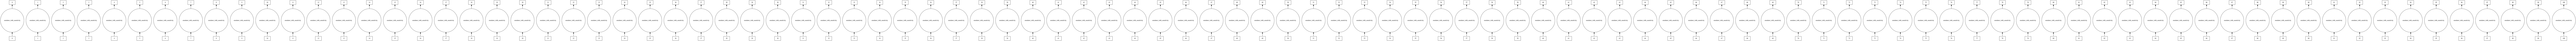

In [9]:
bag_gridcells = db.from_sequence(gridcells)
bag_gridcells = bag_gridcells.map(emulator_with_sensitivity)
bag_gridcells.visualize()

In [ ]:
%%time
results = bag_gridcells.compute()

In [ ]:
y_test = np.array([result[3] for result in results]).ravel()
y_pred = np.array([result[4] for result in results]).ravel()
np.savez_compressed(f'/nobackup/earlacoa/machinelearning/data_annual/emulators/{output}/y_test_pred_{output}.npz', y_test=y_test, y_pred=y_pred)

In [ ]:
rmse_cv = np.mean(np.array([result[5] for result in results]))
r2_cv = np.mean(np.array([result[6] for result in results]))
rmse_test = np.round(np.sqrt(np.abs(mean_squared_error(y_test, y_pred))), decimals=4)
r2_test = np.round(r2_score(y_test, y_pred), decimals=4)

df_eval_summary = df_eval_summary.append([{
    'output': output,
    'rmse_cv': rmse_cv, 
    'r2_cv': r2_cv,                                             
    'rmse_test': rmse_test, 
    'r2_test': r2_test}],              
    ignore_index=True, 
    sort=False
)
df_eval_summary.to_csv(f'/nobackup/earlacoa/machinelearning/data_annual/emulators/{output}/df_eval_summary_{output}.csv')
df_eval_summary

In [ ]:
lats = np.array([result[0] for result in results]).ravel()
lons = np.array([result[1] for result in results]).ravel()
sensitivities = [result[7] for result in results]

for index, sens in enumerate(sensitivities):
    lat = lats[index]
    lon = lons[index]

    for sim_index, sim in enumerate(sims):
        for sens_ind_index, sens_ind in enumerate(sens_inds_S1_ST):
            ds_sens_ind[sens_ind + '_' + sim] = xr.where(
                (ds_sens_ind.coords['lat'] == lat) & (ds_sens_ind.coords['lon'] == lon),
                sens[sens_ind][sim_index],
                ds_sens_ind[sens_ind + '_' + sim]
            )

    for sim_index, sim in enumerate(sims_S2):
        for sens_ind_index, sens_ind in enumerate(sens_inds_S2):
            ds_sens_ind[sens_ind + '_' + sim] = xr.where(
                (ds_sens_ind.coords['lat'] == lat) & (ds_sens_ind.coords['lon'] == lon),
                sens[sens_ind][sims_S2_indexes[sim_index][0], sims_S2_indexes[sim_index][1]],
                ds_sens_ind[sens_ind + '_' + sim]
            )

ds_sens_ind.to_netcdf(f'/nobackup/earlacoa/machinelearning/data_annual/emulators/{output}/ds_sens_ind_{output}.nc')